# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import logging
import requests
import re

import sys
import joblib
import os
# from dotenv import load_dotenv
import boto3
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import scipy
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, normalize
from sklearn.metrics import mean_squared_error, mean_absolute_error, ndcg_score
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Dataset, Reader, SVD, NormalPredictor, accuracy

from implicit.als import AlternatingLeastSquares

from catboost import CatBoostClassifier, Pool

# Suppress warnings
import warnings

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

In [4]:
# Параметры загрузки в storage
endpoint_url = os.environ.get('ENDPOINT_URL')
bucket_name = os.environ.get('S3_BUCKET_NAME')
url = f's3://{bucket_name}'

In [5]:
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('recommendations', exist_ok=True)

# ЭТАП 1. Подготовка данных

## Загрузка первичных данных

In [6]:
initial_df = pd.read_csv("./data/initial_data.csv")

## Обзор данных

In [7]:
print(initial_df.info())
display(initial_df.head())
print(initial_df.isna().sum())
# print(initial_df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   fecha_dato             object 
 1   ncodpers               int64  
 2   ind_empleado           object 
 3   pais_residencia        object 
 4   sexo                   object 
 5   age                    object 
 6   fecha_alta             object 
 7   ind_nuevo              float64
 8   antiguedad             object 
 9   indrel                 float64
 10  ult_fec_cli_1t         object 
 11  indrel_1mes            object 
 12  tiprel_1mes            object 
 13  indresi                object 
 14  indext                 object 
 15  conyuemp               object 
 16  canal_entrada          object 
 17  indfall                object 
 18  tipodom                float64
 19  cod_prov               float64
 20  nomprov                object 
 21  ind_actividad_cliente  float64
 22  renta           

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1.0,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1.0,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1.0,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


fecha_dato                      0
ncodpers                        0
ind_empleado                27734
pais_residencia             27734
sexo                        27804
age                             0
fecha_alta                  27734
ind_nuevo                   27734
antiguedad                      0
indrel                      27734
ult_fec_cli_1t           13622516
indrel_1mes                149781
tiprel_1mes                149781
indresi                     27734
indext                      27734
conyuemp                 13645501
canal_entrada              186126
indfall                     27734
tipodom                     27735
cod_prov                    93591
nomprov                     93591
ind_actividad_cliente       27734
renta                     2794375
segmento                   189368
ind_ahor_fin_ult1               0
ind_aval_fin_ult1               0
ind_cco_fin_ult1                0
ind_cder_fin_ult1               0
ind_cno_fin_ult1                0
ind_ctju_fin_u

In [8]:
# Список банковских продуктов
pattern = r"^ind_[a-z_]*_ult1$"  # Регулярное выражение для соответствия шаблону
items_list = [col for col in initial_df.columns if re.match(pattern, col)]
print(items_list)

['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']


In [ ]:
# Клиентские признаки
client_features_list = ['ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel',
       'ult_fec_cli_1t', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext',
       'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'cod_prov',
       'nomprov', 'ind_actividad_cliente', 'renta', 'segmento']

In [10]:
# Изменим типы данных в столбцах в соответствии с их содержанием

# Временные признаки
for cols in ['fecha_dato', 'fecha_alta', 'ult_fec_cli_1t']:
    initial_df[cols] = pd.to_datetime(initial_df[cols])

# Числовые признаки
for cols in ['age', 'antiguedad']:
    initial_df[cols] = pd.to_numeric(initial_df[cols], errors='coerce')

In [11]:
# Количество уникальных значений в столбцах типа 'object'
cat_features = initial_df.select_dtypes(include='object')
unique_values_per_col = cat_features.nunique(dropna=False)
unique_values_per_col

ind_empleado         6
pais_residencia    119
sexo                 3
indrel_1mes         14
tiprel_1mes          6
indresi              3
indext               3
conyuemp             3
canal_entrada      163
indfall              3
nomprov             53
segmento             4
dtype: int64

In [12]:
# Визуальная оценка возможных значений различных признаков
print(initial_df['pais_residencia'].value_counts(dropna=False))
print(initial_df['indrel_1mes'].value_counts(dropna=False))
print(initial_df['tiprel_1mes'].value_counts(dropna=False))
print(initial_df['conyuemp'].value_counts(dropna=False))
print(initial_df['canal_entrada'].value_counts(dropna=False))
print(initial_df['nomprov'].value_counts(dropna=False))
print(initial_df['segmento'].value_counts(dropna=False))

pais_residencia
ES     13553710
NaN       27734
FR         5161
AR         4835
DE         4625
GB         4605
US         3651
CO         3526
IT         2947
RO         2931
MX         2573
BR         2351
VE         2331
EC         2169
CH         1995
BE         1526
BO         1514
PY         1430
PT         1419
CL          989
PE          900
RU          769
CU          758
NL          757
SE          603
PL          599
CN          563
UY          510
UA          493
AT          476
BG          476
CA          446
AU          424
DO          424
IL          413
IE          409
MA          396
FI          345
HN          282
GR          243
JP          239
DK          226
AE          221
NG          214
IN          187
CR          147
NO          136
GT          130
LU          124
ZA          119
GQ          119
SG          117
AD          111
BY          102
TH          102
SV          102
CZ          102
PR          101
KR           96
MD           96
DZ           86
PK      

<mark>Выводы.</mark> 
1. Столбец 'indrel_1mes' содержит разные обозначения одних и тех же категорий. Необходимо устранить разнообразие.
2. Значения признака 'conyuemp' не соответствуют описанию датасета: "conyuemp = 1, если клиент супруг(а) работника". Малоинформативный признак, содержит очень много пропусков. Вряд ли его учёт окажет существенное влияние на качество рекомендаций.
3. Признаки 'cod_prov' (код провинции) и 'nomprov' (имя провинции) дублируют друг друга по смыслу. Для моделирования достаточно использовать один из них.
4. Значения признака 'segmento' целесообразно сделать числовым, "отбросив" текстовую расшифровку.

In [ ]:
# Столбец 'indrel_1mes' содержит разные обозначения одних и тех же категорий. Необходимо устранить разнообразие.
initial_df['indrel_1mes'] = initial_df['indrel_1mes'].replace('P', '5')
initial_df['indrel_1mes'] = pd.to_numeric(initial_df['indrel_1mes'], errors='ignore')
print(initial_df['indrel_1mes'].value_counts(dropna=False))

indrel_1mes
1.0    13490681
NaN      149781
3.0        4350
2.0        1317
5.0         874
4.0         306
Name: count, dtype: int64


In [14]:
# Значения признака 'segmento' целесообразно сделать числовым, "отбросив" текстовую расшифровку.
initial_df['segmento'] = initial_df['segmento'].str.extract('^(\d+)', expand=False)
initial_df['segmento'] = pd.to_numeric(initial_df['segmento'], errors='raise')
print(initial_df['segmento'].value_counts(dropna=False))

segmento
2.0    7960220
3.0    4935579
1.0     562142
NaN     189368
Name: count, dtype: int64


Ряд признаков содержат большое количество маленьких категорий. Маленькой будем считать категории с количеством записей менее 100000, хотя это вопрос спорный. Объединим категории с количеством записей менее 100000 в одну - 'other'.

In [15]:
%%script false --no-raise-error
# TODO Спорный вопрос
for feat in ['pais_residencia', 'canal_entrada', 'nomprov']:
    cat_frequency = initial_df[feat].value_counts()
    small_cat = cat_frequency[cat_frequency < 100000].index
    initial_df.loc[initial_df[feat].isin(small_cat), feat] = 'other'

In [16]:
# Стало
cat_features = initial_df.select_dtypes(include='object')
unique_values_per_col = cat_features.nunique(dropna=False)
unique_values_per_col

ind_empleado         6
pais_residencia    119
sexo                 3
tiprel_1mes          6
indresi              3
indext               3
conyuemp             3
canal_entrada      163
indfall              3
nomprov             53
dtype: int64

## EDA

In [18]:
# Количество клиентов
print(initial_df['ncodpers'].nunique())

956645


In [19]:
# Временной интервал, в рамках которого рассматриваем потребительское поведение
print(initial_df['fecha_dato'].min())
print(initial_df['fecha_dato'].max())

2015-01-28 00:00:00
2016-05-28 00:00:00


In [20]:
# Временной интервал, в рамках были заключены клиентские договоры
print(initial_df['fecha_alta'].min())
print(initial_df['fecha_alta'].max())

1995-01-16 00:00:00
2016-05-31 00:00:00


Модели МО не работают с признаками даты и времени напрямую. Необходимо преобразовать такие признаки в числовые или категориальные. Оценим общий стаж клиента с момента заключения договора. 

In [21]:
# Общий стаж
initial_df['experience_general'] = (initial_df['fecha_dato'] - initial_df['fecha_alta']).dt.days / 30.44 # Среднее количество дней в месяце
initial_df['experience_general'] = initial_df['experience_general'].round(0)

In [23]:
# Проверка
display(initial_df[initial_df['ncodpers']==1375586]
        [['fecha_dato', 'fecha_alta', 'antiguedad', 'ind_nuevo',
          'indrel', 'ult_fec_cli_1t', 'indrel_1mes', 
          'experience_general']])

display(initial_df[initial_df['ncodpers']==54195]
        [['fecha_dato', 'fecha_alta', 'antiguedad',
          'indrel', 'ult_fec_cli_1t', 'indrel_1mes', 
          'experience_general']])

,fecha_dato,fecha_alta,antiguedad,ind_nuevo,indrel,ult_fec_cli_1t,indrel_1mes,experience_general
0,2015-01-28,2015-01-12,6.0,0.0,1.0,NaT,1.0,1.0
1047196,2015-02-28,2015-01-12,6.0,0.0,1.0,NaT,1.0,2.0
1681276,2015-03-28,2015-01-12,6.0,0.0,1.0,NaT,1.0,2.0
2299297,2015-04-28,2015-01-12,6.0,0.0,1.0,NaT,1.0,3.0
2714121,2015-05-28,2015-01-12,6.0,0.0,1.0,NaT,1.0,4.0
3343336,2015-06-28,2015-01-12,6.0,0.0,1.0,NaT,1.0,5.0
4581564,2015-07-28,2015-01-12,6.0,0.0,1.0,NaT,1.0,6.0
5075380,2015-08-28,2015-01-12,7.0,0.0,1.0,NaT,1.0,7.0
6258167,2015-09-28,2015-01-12,8.0,0.0,1.0,NaT,1.0,9.0
6572487,2015-10-28,2015-01-12,9.0,0.0,1.0,NaT,1.0,9.0


,fecha_dato,fecha_alta,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,experience_general
427792,2015-01-28,1997-01-20,222.0,1.0,NaT,1.0,216.0
825421,2015-02-28,1997-01-20,222.0,1.0,NaT,1.0,217.0
1466604,2015-03-28,1997-01-20,222.0,1.0,NaT,1.0,218.0
2081426,2015-04-28,1997-01-20,222.0,1.0,NaT,1.0,219.0
2944944,2015-05-28,1997-01-20,222.0,1.0,NaT,1.0,220.0
3576952,2015-06-28,1997-01-20,222.0,1.0,NaT,1.0,221.0
4061520,2015-07-28,1997-01-20,222.0,1.0,NaT,1.0,222.0
5313130,2015-08-28,1997-01-20,223.0,1.0,NaT,1.0,223.0
5699517,2015-09-28,1997-01-20,224.0,1.0,NaT,1.0,224.0
6928049,2015-10-28,1997-01-20,225.0,1.0,NaT,1.0,225.0


<mark>Выводы.</mark> 
1. При исседовании признака antiguedad "Стаж клиента (в месяцах)" в датасете обнаружена следующая аномалия: в интервале с 2015-01-28 по 2015-07-28 значения antiguedad для одного и того же клиента не меняются, хотя это динамический признак, который должен увеличиваться на единицу с каждым месяцем. Несколько примеров приведено выше. В принципе, можно не исправлять, поскольку при обучении модели необходима информация о стаже в 2016 г., а в соответствующей части датасета аномалий не обнаружено.
2. Особенностью признака antiguedad является обнуление стажа при изменении его типа (см. indrel_1mes), что продемонстрировано выше для клиента с id=54195. Таким образом, при создании рекомендательной системы целесообразно использовать имеющийся признак antiguedad вместе с experience_general (общий стаж с момента заключения договора).

In [24]:
# ind_nuevo	= 1, если клиент зарегистрировался за последние 6 месяцев
print(initial_df['ind_nuevo'].value_counts(dropna=False))

ind_nuevo
0.0    12808368
1.0      811207
NaN       27734
Name: count, dtype: int64


In [25]:
# Проверка корректности значений в столбце ind_nuevo
print(initial_df[(initial_df['experience_general'] <= 6) &
                 (initial_df['ind_nuevo']==1)].shape[0])
print(initial_df[(initial_df['experience_general'] <= 6) &
                 (initial_df['ind_nuevo']==0)].shape[0])
print(initial_df[(initial_df['experience_general'] <= 6)].shape[0])

781685
282858
1064543


<mark>Вывод.</mark> Признак ind_nuevo (1, если клиент зарегистрировался за последние 6 месяцев) является производным от experience_general, однако его значения не всегда корректны. См. пример для клиента с id=1375586 выше.

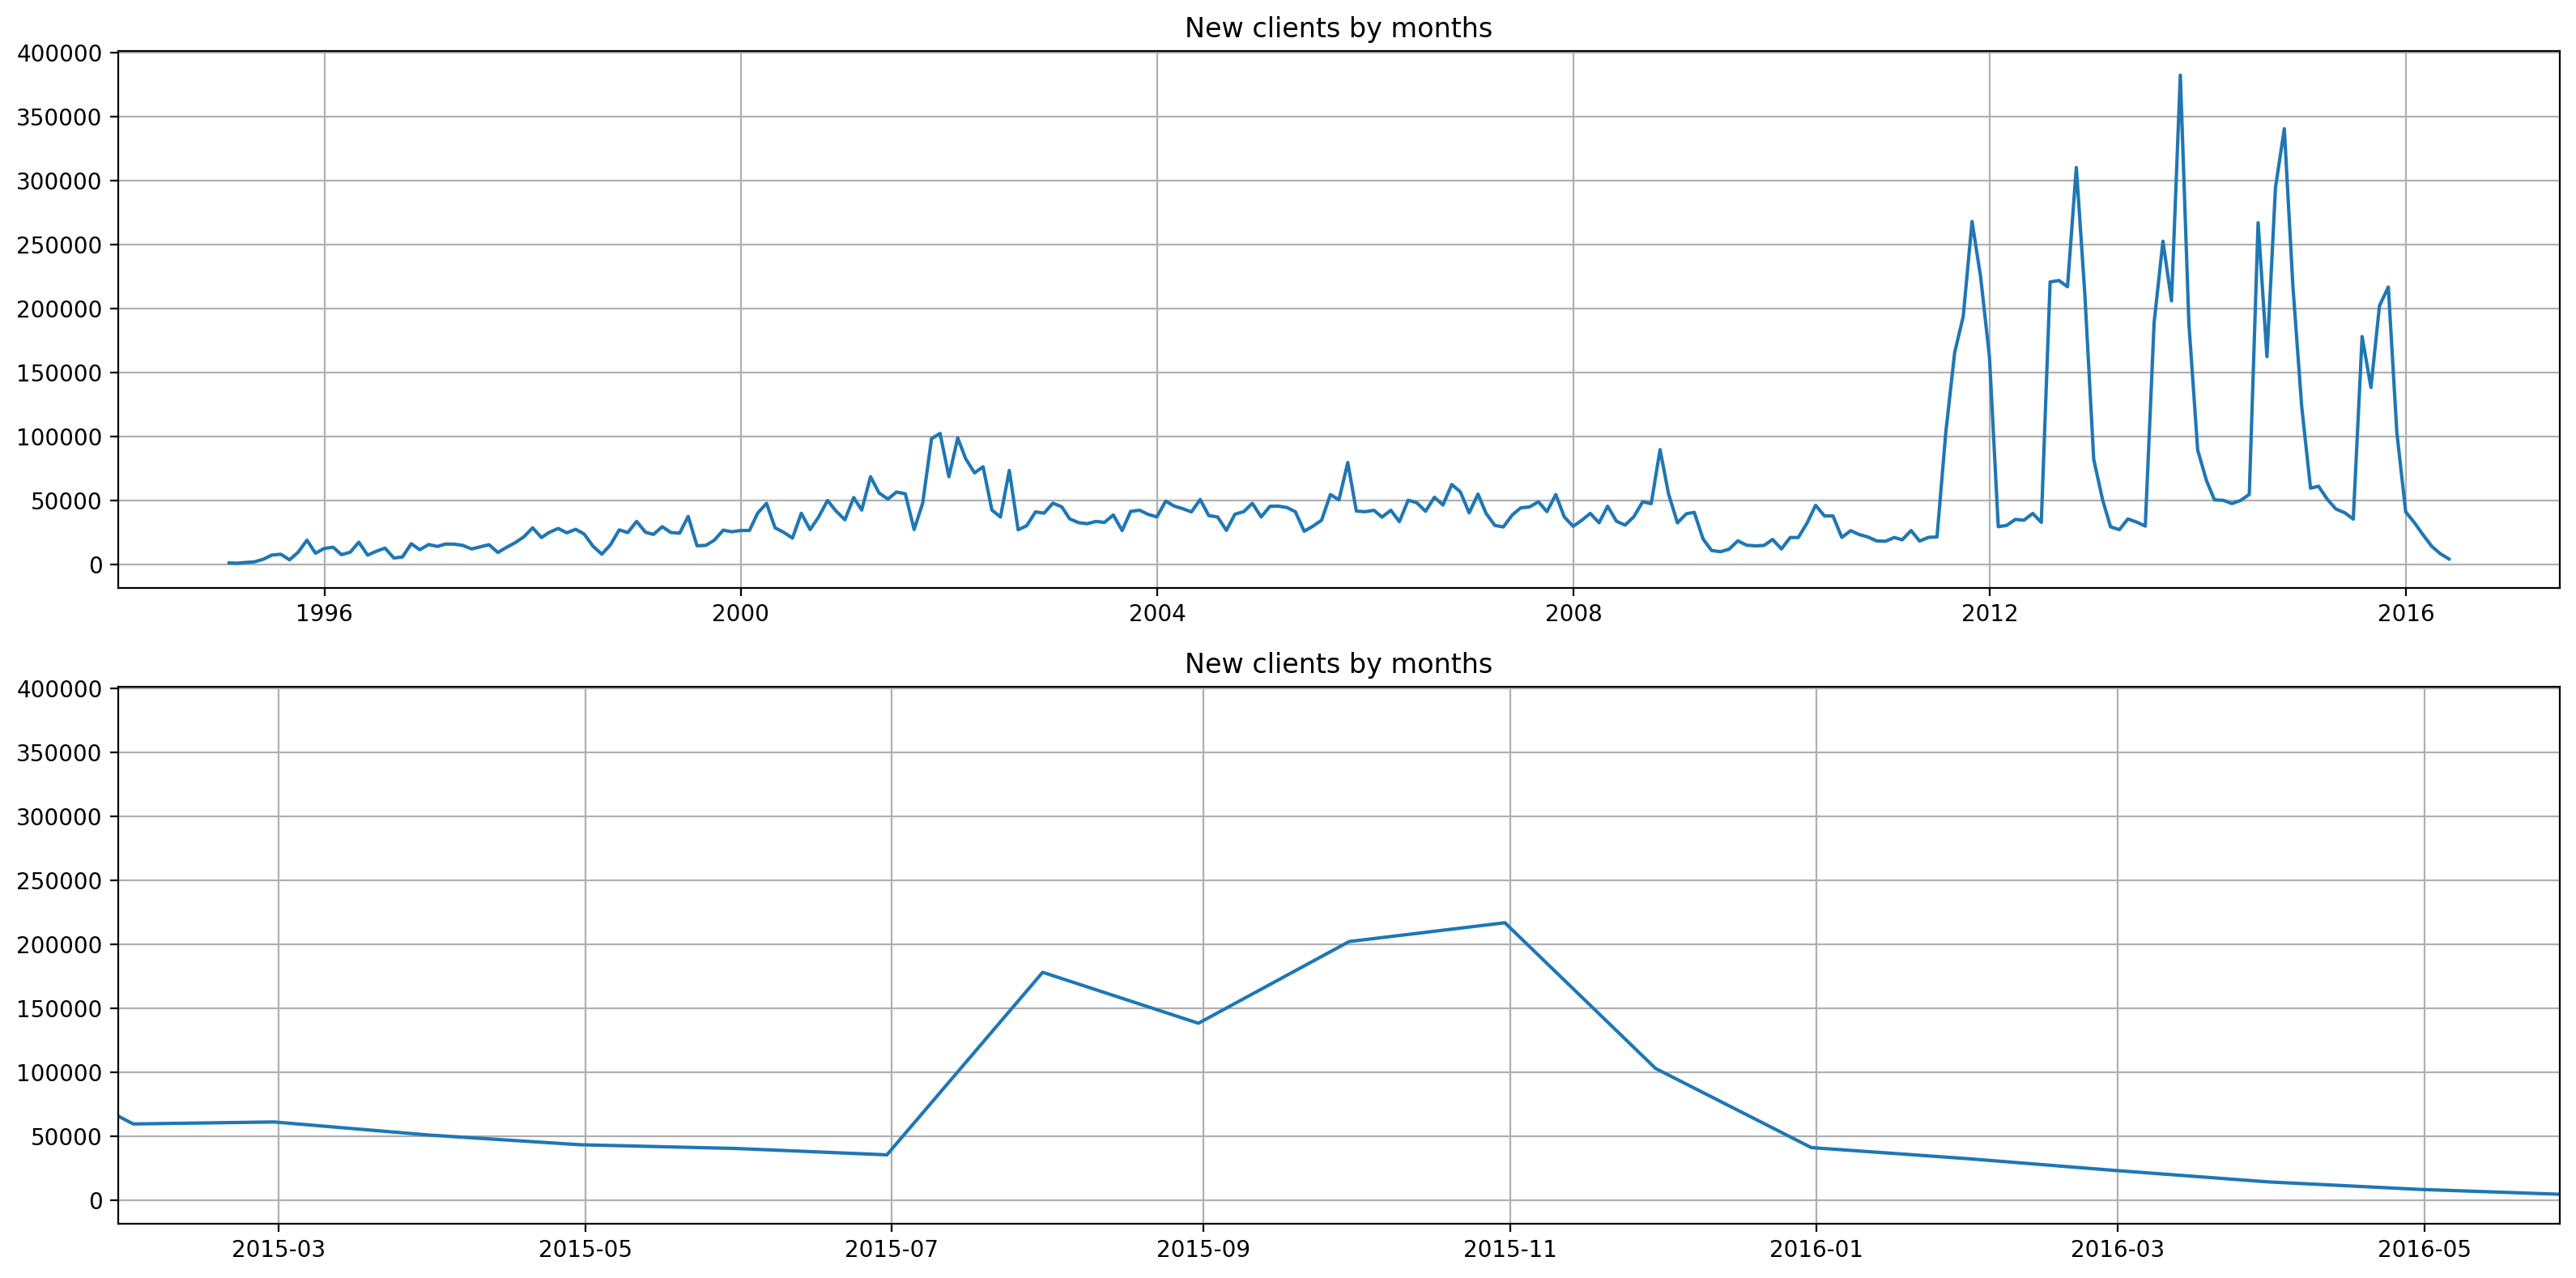

In [ ]:
# Заменяем дату, когда клиент впервые заключил договор в банке, на последний день месяца
initial_df['started_at_month'] = initial_df['fecha_alta'].dt.to_period('M').dt.end_time.dt.date
interactions_by_month = initial_df.groupby("started_at_month").agg(new_clients_count=("fecha_alta", "count")).reset_index()

# Распределение новых клиентов по месяцам
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

for i in range(2):
    axs[i].plot(interactions_by_month["started_at_month"], interactions_by_month["new_clients_count"])
    axs[i].grid()
    axs[i].set_title("New clients by months")

axs[1].set_xlim(initial_df['fecha_dato'].min(), 
            initial_df['fecha_dato'].max())

fig.tight_layout()

<mark>Вывод.</mark> На протяжении последних пяти лет наблюдается сезонность в притоке новых клиентов: в во втором полугодии видны "всплески". В контексте решения задачи это можно игнорировать, поскольку target и test периоды расположены в первой половине 2016 г. и "всплески" не "захватывают".

In [ ]:
display(initial_df[initial_df[client_features_list].isna().all(axis=1)].head())
display(initial_df[initial_df[client_features_list].isna().all(axis=1)].shape[0])
display(initial_df[initial_df[client_features_list].isna().all(axis=1)]['ncodpers'].nunique())

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,experience_general,started_at_month
261,2015-01-28,1050741,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,NaN,NaT
1029,2015-01-28,1051017,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,NaN,NaT
1063,2015-01-28,1051064,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,NaN,NaT
1154,2015-01-28,1051387,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,NaN,NaT
1779,2015-01-28,1048660,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,NaN,NaT


27734

7340

<mark>Вывод.</mark> Есть группа клиентов (7340 чел.), для которых неизвестны значения клиентских признаков. В принципе, для таких клиентов возможно получение рекомендаций на основе коллаборативной фильтрации, поскольку доступна информация о имеющихся у них банковских продуктах. Вместе с тем, ранжирование этих рекомендаций на основе клиентских признаков уже невозможно, поскольку вместо значений этих признаков имеем NaN.

In [28]:
renta_df = initial_df.groupby(by='ncodpers')[['renta']].last()
renta_df[['renta']].describe()

,renta
count,7.094110e+05
mean,1.340964e+05
std,2.322812e+05
min,1.202730e+03
25%,6.848994e+04
50%,1.014893e+05
75%,1.555271e+05
max,2.889440e+07


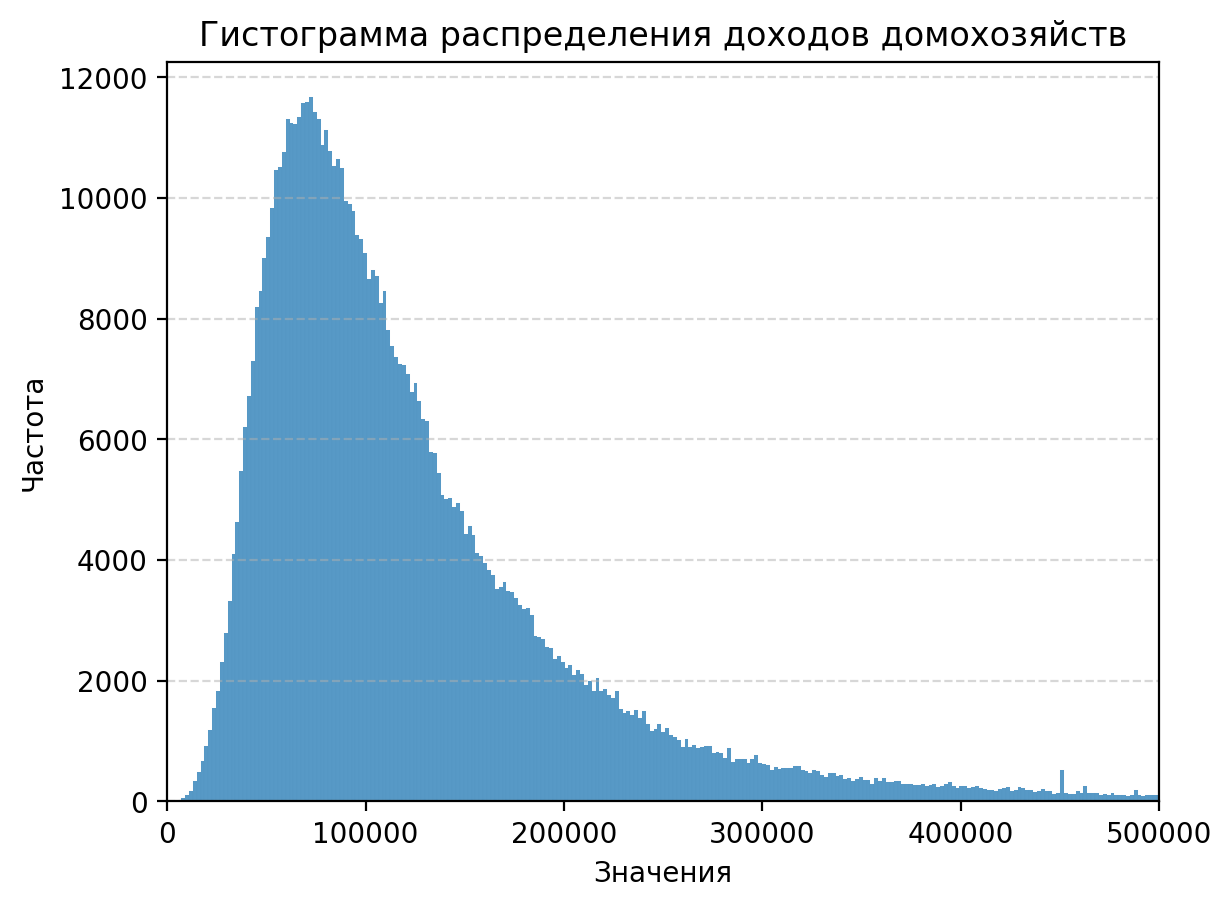

In [29]:
# Построение гистограммы с помощью Seaborn
sns.histplot(data=renta_df, 
             x='renta') # используем histplot
# Устанавливаем границы по оси X
plt.xlim(0, 5e+05)
# Добавляем координатную сетку только по оси Y, пунктирной линией, с прозрачностью 0.5
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('Гистограмма распределения доходов домохозяйств')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

In [30]:
renta_df[renta_df['renta']>5e+05].shape[0] / renta_df.shape[0]

0.009639939580513148

<mark>Вывод.</mark> В распределении доходов домохозяйств (renta) аномалий не обнаружено.

## Выводы

- Данные охватывают временной интервал с 2015-01-28 по 2016-05-28 (столбец 'fecha_dato'). При этом клиентские договоры (столбец 'fecha_alta') были заключены в период с 1995-01-16 по 2016-05-31.
- Датасет содержит информацию о 956645 клиентах.
- Есть группа клиентов (7340 чел.), для которых неизвестны значения клиентских признаков. В принципе, для таких клиентов возможно получение рекомендаций на основе коллаборативной фильтрации, поскольку доступна информация о имеющихся у них банковских продуктах. Вместе с тем, ранжирование этих рекомендаций на основе клиентских признаков уже невозможно, поскольку вместо значений этих признаков имеем NaN.
- На протяжении последних пяти лет наблюдается сезонность в притоке новых клиентов: в во втором полугодии видны "всплески". В контексте решения задачи это можно игнорировать, поскольку target и test периоды расположены в первой половине 2016 г. и "всплески" не "захватывают".
- Значения признака 'conyuemp' не соответствуют описанию датасета: "conyuemp = 1, если клиент супруг(а) работника". Малоинформативный признак, содержит очень много 99,99% пропусков. Вряд ли его учёт окажет существенное влияние на качество рекомендаций.
- Признаки 'cod_prov' (код провинции) и 'nomprov' (имя провинции) дублируют друг друга по смыслу. Для моделирования достаточно использовать один из них.
- При исседовании признака antiguedad "Стаж клиента (в месяцах)" в датасете обнаружена следующая аномалия: в интервале с 2015-01-28 по 2015-07-28 значения antiguedad для одного и того же клиента не меняются, хотя это динамический признак, который должен увеличиваться на единицу с каждым месяцем. В принципе, можно не исправлять, поскольку при обучении модели необходима информация о стаже в 2016 г., а в соответствующей части датасета аномалий не обнаружено.
- Особенностью признака antiguedad является обнуление стажа при изменении его типа (см. indrel_1mes), что продемонстрировано выше для клиента с id=54195. Таким образом, при создании рекомендательной системы целесообразно использовать имеющийся признак antiguedad вместе с дополнительным experience_general (общий стаж с момента заключения договора).
- Признак ind_nuevo (1, если клиент зарегистрировался за последние 6 месяцев) является производным от experience_general, однако его значения не всегда корректны.

## Сохранение данных

In [29]:
initial_df.to_parquet('data/prepared_data.parquet')

In [ ]:
file_path = 'prepared_data/'
object_key = 'recsys/data/'

# Создаем клиент S3 с кастомным endpoint
s3_client = boto3.client(
    's3',
    endpoint_url=endpoint_url,
    # region_name='ru-central1',  # можно указать регион, если нужно
    aws_access_key_id=os.environ.get('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.environ.get('AWS_SECRET_ACCESS_KEY'),
)

# Загрузка файла
for file in ('items.parquet', 'events.parquet'):
    try:
        s3_client.upload_file((file_path + file), bucket_name, (object_key + file))
        print(f"Файл {file} успешно загружен в {url}/{object_key}")

    except Exception as e:
        print(f"Произошла ошибка при загрузке файла: {e}")

Файл items.parquet успешно загружен в s3://s3-student-mle-20250226-e7b4c7010d/recsys/data/
Файл events.parquet успешно загружен в s3://s3-student-mle-20250226-e7b4c7010d/recsys/data/


## Очистка памяти

In [33]:
del initial_df

# ЭТАП 2. Моделирование

# Загрузка предобработанных данных

In [6]:
prepared_df = pd.read_parquet('data/prepared_data.parquet')
prepared_df = prepared_df.rename(columns={'ncodpers': 'user_id'})

In [7]:
prepared_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 50 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   fecha_dato             datetime64[ns]
 1   user_id                int64         
 2   ind_empleado           object        
 3   pais_residencia        object        
 4   sexo                   object        
 5   age                    float64       
 6   fecha_alta             datetime64[ns]
 7   ind_nuevo              float64       
 8   antiguedad             float64       
 9   indrel                 float64       
 10  ult_fec_cli_1t         datetime64[ns]
 11  indrel_1mes            float64       
 12  tiprel_1mes            object        
 13  indresi                object        
 14  indext                 object        
 15  conyuemp               object        
 16  canal_entrada          object        
 17  indfall                object        
 18  tipodom             

In [8]:
pattern = r"^ind_[a-z_]*_ult1$"  # Регулярное выражение для соответствия шаблону

# Список банковских продуктов
items_list = [col for col in prepared_df.columns if re.match(pattern, col)]
print(items_list)

['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']


In [9]:
# Клиентские признаки
client_features_list = ['ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel',
       'ult_fec_cli_1t', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext',
       'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'cod_prov',
       'nomprov', 'ind_actividad_cliente', 'renta', 'segmento']

# Деление выборки на части

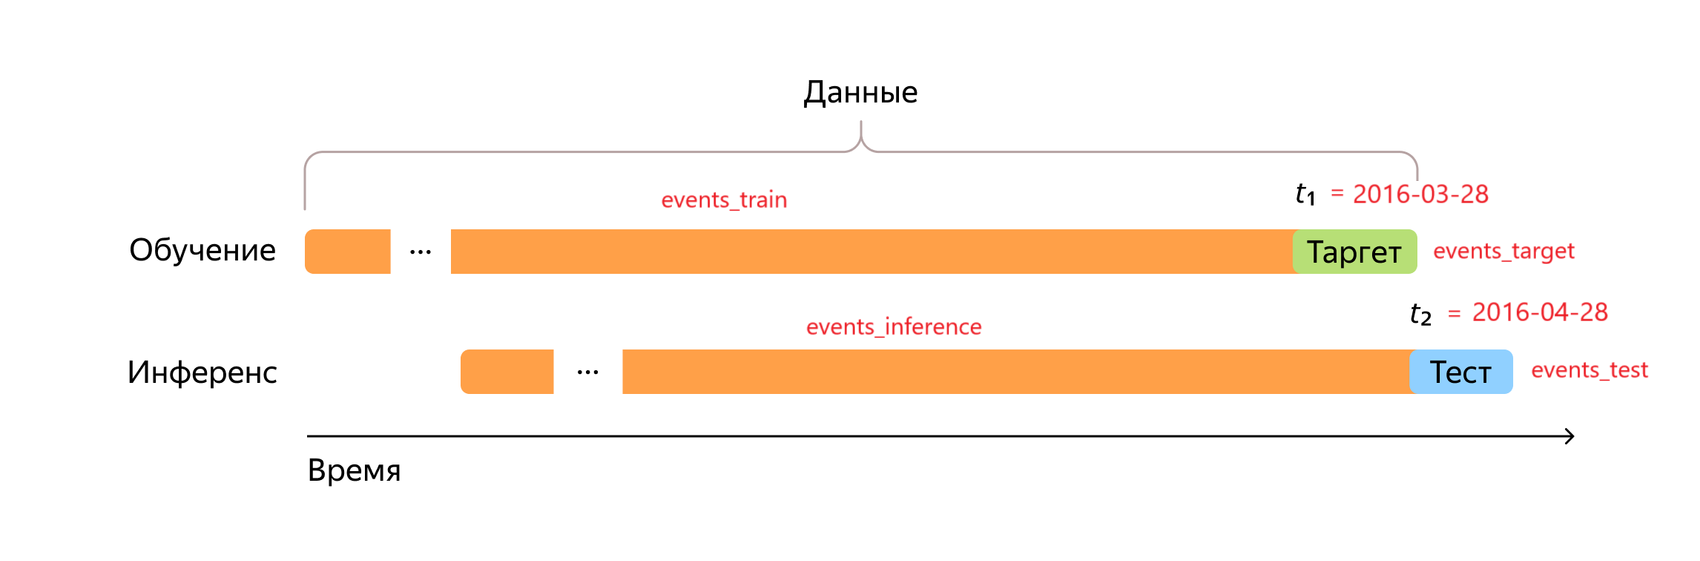

In [10]:
# Зададим точки разбиения
train_split_date = pd.to_datetime("2016-03-28")
test_split_date = pd.to_datetime("2016-04-28")

# Делим выборку на части
train_split_date_idx = prepared_df["fecha_dato"] <= train_split_date
target_split_date_idx = prepared_df["fecha_dato"].between(train_split_date, 
                                                          test_split_date,
                                                          inclusive='right')
test_split_date_idx = prepared_df["fecha_dato"] > test_split_date

train_df = prepared_df[train_split_date_idx]
target_df = prepared_df[target_split_date_idx]
inference_df = pd.concat([train_df, target_df])
test_df = prepared_df[test_split_date_idx]


In [11]:
# Оценим объёмы выборок в долях от общей
print(train_df.shape[0] / prepared_df.shape[0])
print(target_df.shape[0] / prepared_df.shape[0])
print(inference_df.shape[0] / prepared_df.shape[0])
print(test_df.shape[0] / prepared_df.shape[0])

0.8637293989606303
0.06801883067203945
0.9317482296326697
0.0682517703673303


In [12]:
del prepared_df

<mark>Вывод.</mark> Выборка для обучения модели ранжирования содержит примерно 7% всех записей, тестовая - 7%. Сложно сказать, достаточые ли это объёмы. Необходимы дополнительные эксперименты.

# Покупки в target и test периодах

In [13]:
def define_events(inference_df: pd.DataFrame, test_df: pd.DataFrame) -> pd.DataFrame:
    
    # Оставим строки с информацией об имеющихся у "старых" клиентов продуктах на момент обучения (переобучения) модели
    values4old_users = inference_df[(inference_df['fecha_dato']==inference_df['fecha_dato'].max()) &
                                     inference_df['user_id'].isin(test_df['user_id'])][['user_id', 'fecha_dato'] + items_list]

    # Добавим строки с информацией об имеющихся продуктах у "старых" клиентов в рассматриваемом периоде
    values4old_users = pd.concat([values4old_users, 
                                 (test_df[test_df['user_id'].isin(values4old_users['user_id'])]
                                         [['user_id', 'fecha_dato'] + items_list])])

    # Информация о продуктах, приобретённых в рассматриваемом периоде "старыми" клиентами.
    values4old_users = values4old_users.sort_values(by=['user_id', 'fecha_dato'])
    values4old_users[items_list] = values4old_users.groupby(by='user_id')[items_list].diff()
    values4old_users.dropna(inplace=True)

    # Информация о продуктах, приобретённых в рассматриваемом периоде новыми и 
    # вернувшимися после перерыва "старыми" клиентами.
    values4new_users = (test_df[(~test_df['user_id'].isin(values4old_users['user_id']))]
                               [['user_id', 'fecha_dato'] + items_list])
    
    # Информация о продуктах, приобретённых клиентами в рассматриваемом периоде
    values4test_users = pd.concat([values4old_users, values4new_users])

    # Проверки (вместо логгирования)
    print('Количество новых и вернувшихся после перерыва "старых" клиентов')
    print(values4new_users.shape[0])
    print('Количество "старых" клиентов без учёта вернувшихся')
    print(values4old_users.shape[0])
    print('Общее количество клиентов в рассматриваемом периоде')
    print(test_df.shape[0])
    # print(values4test_users.shape[0])
    print('Количество клиентов, совершивших хотя бы одну покупку в рассматриваемом периоде')
    print(values4test_users[values4test_users[items_list].isin([1]).any(axis=1)].shape[0])
    print('Доля клиентов, совершивших хотя бы одну покупку в рассматриваемом периоде')
    print(values4test_users[values4test_users[items_list].isin([1]).any(axis=1)].shape[0] / 
          values4test_users.shape[0])
    
    # Оставим строки, соответствующие событию "в рассматриваемом периоде приобретён банковский продукт"
    values4test_users = values4test_users[values4test_users[items_list].isin([1]).any(axis=1)]
    values4test_users.drop(columns=['fecha_dato'], inplace=True, errors='ignore')

    # Меняем формат таблицы на "длинный"
    events_df = pd.melt(values4test_users,
                        id_vars=['user_id'],  # Столбцы, которые нужно оставить без изменений (идентификаторы)
                        value_vars=items_list,  # Столбцы, которые нужно "расплавить"
                        var_name='item_id',  # Имя столбца для названий переменных (продуктов)
                        value_name='target')  # Имя столбца для значений (фактов покупки продукта)
    # Оставим строки, соответствующие событию "в рассматриваемом периоде приобретён банковский продукт"
    events_df = events_df[events_df['target']==1]
    return events_df

In [14]:
# Получаем информацию о покупках в target периоде
# events_target_df = define_events(train_df, target_df)
# events_target_df.head()

In [15]:
# Получаем информацию о покупках в test периоде
# events_test_df = define_events(inference_df, test_df)
# events_test_df.head()

# Топ популярных объектов

Определим наиболее популярные банковские продукты, которые новые клиенты приобретают в 1-ю очередь после заключения договора банковского обслуживания.

In [33]:
# Рассматриваемый период
print(inference_df['fecha_dato'].min() - pd.Timedelta('27days'))
print(test_split_date)

2015-01-01 00:00:00
2016-04-28 00:00:00


In [34]:
# Шаг 1. Выделим клиентов, заключивших договор с банком в рассматриваемый период.
# Шаг 2. Определим продукты, которые приобретены клиентами в 1-ю очередь.
# Шаг 3. Определим количество приобретённых в 1-ю очередь продуктов.
top_k_pop_items = (inference_df[inference_df['fecha_alta']
                   .between((inference_df['fecha_dato'].min() - pd.Timedelta('27days')),
                             test_split_date)]
                   .groupby('user_id')[items_list]
                   .first()
                   .sum()
                   .sort_values(ascending=False))

In [35]:
top_k_pop_items = (top_k_pop_items[top_k_pop_items > 0]
                   .astype("int")
                   .to_frame(name='count')
                   .reset_index(names='item_id')
                   )

In [36]:
# нормализация
scaler = MinMaxScaler()
top_k_pop_items['score'] = scaler.fit_transform(top_k_pop_items[['count']])

In [37]:
top_k_pop_items.head(10)

,item_id,count,score
0,ind_cco_fin_ult1,89575,1.000000
1,ind_ctma_fin_ult1,2189,0.024416
2,ind_deco_fin_ult1,1973,0.022004
3,ind_recibo_ult1,1199,0.013363
4,ind_cno_fin_ult1,839,0.009344
5,ind_nom_pens_ult1,766,0.008529
6,ind_nomina_ult1,749,0.008340
7,ind_ctju_fin_ult1,706,0.007860
8,ind_dela_fin_ult1,602,0.006698
9,ind_ecue_fin_ult1,134,0.001474


<mark>Вывод.</mark> Наиболее популярным продуктом, приобритаемым после заключения договора, является "Текущий счет" (ind_cco_fin_ult1). Следующим по популярности продуктами являются "Особый счёт 3" (ind_ctma_fin_ult1) и "Краткосрочный депозит" (ind_deco_fin_ult1).

In [38]:
# Сохраним полученные объекты в файл
top_k_pop_items = top_k_pop_items[['item_id', 'score']]
top_k_pop_items.to_parquet('recommendations/top_popular.parquet')

# Получение рекомендаций U2I с помощью ALS

In [ ]:
def als_model(user_item_df: pd.DataFrame, user_ids_encoded, 
              user_encoder: LabelEncoder, items_dec_dict: dict,
              file_model: str, file_rec: str):
    
    # TODO Добавить описание

    # ====== ОБУЧЕНИЕ МОДЕЛИ ==============
    # Создаём sparse-матрицу формата CSR 
    user_item_matrix = scipy.sparse.csr_matrix(user_item_df, dtype=np.int8)

    # Создаём модель рекомендаций
    model = AlternatingLeastSquares(factors=50, # количество латентных факторов
                                    iterations=25, 
                                    regularization=0.05, 
                                    random_state=0)
    model.fit(user_item_matrix) 

    # сохранение модели в файл
    with open(f'models/{file_model}.pkl', 'wb') as fd:
        joblib.dump(model, fd)
    
    print('Модель получена и сохранена!')
    
    # ====== ПОЛУЧЕНИЕ РЕКОМЕНДАЦИЙ ==============
    # получаем рекомендации для всех пользователей
    recom = model.recommend(
        user_ids_encoded, 
        user_item_matrix[user_ids_encoded], 
        filter_already_liked_items=False, # фильтровать уже понравившиеся элементы 
        N=5) # Получаем 5 рекомендаций для каждого клиента
    
    # преобразуем полученные рекомендации в табличный формат
    item_ids_enc = recom[0]
    als_scores = recom[1]

    recom = pd.DataFrame({
        "user_id_enc": user_ids_encoded,
        "item_id_enc": item_ids_enc.tolist(), 
        "score": als_scores.tolist()})
    # Метод explode() используется в Pandas для преобразования каждой строки, 
    # содержащей список или кортеж, в несколько строк.
    recom = recom.explode(["item_id_enc", "score"], ignore_index=True)

    # приводим типы данных
    recom["item_id_enc"] = recom["item_id_enc"].astype("int")
    recom["score"] = recom["score"].astype("float")

    # получаем изначальные идентификаторы
    recom["user_id"] = user_encoder.inverse_transform(recom["user_id_enc"])
    recom["item_id"] = recom["item_id_enc"].map(items_dec_dict)
    recom = recom.drop(columns=["user_id_enc", "item_id_enc"])

    # Сохраним полученные рекомендации в файл
    recom = recom[["user_id", "item_id", "score"]]
    recom.to_parquet(f"recommendations/{file_rec}.parquet")
    print('Рекомендации получены и сохранены!')
    pass

## Рекомендации U2I на данных train_df

In [ ]:
# Определим длительность владения продуктами в рамках обучающего периода
train_df[items_list] = train_df[items_list].fillna(0)
u2i_train_df = train_df.groupby(by='user_id')[items_list].sum()
u2i_train_df = u2i_train_df.astype("int")

In [ ]:
u2i_train_df.head()

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
user_id,,,,,,,,,,,,,,,,,,,,,,,,
15889,0,0,15,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,7,15,0,0,0,0
15890,0,0,0,0,15,0,0,0,15,0,0,0,15,0,0,15,0,0,15,0,0,15,15,15
15891,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15892,0,0,10,0,5,0,0,0,0,0,0,13,15,0,0,0,0,15,15,15,0,0,0,15
15893,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,15,0,0,0,0


In [ ]:
# Подсчитываем количество строк, где есть хотя бы одно значение 1
print(u2i_train_df[u2i_train_df.any(axis=1)].shape[0])
print(u2i_train_df.shape[0])

724392
947198


In [ ]:
# Обозначим факты владения банковскими продуктами 1
u2i_train_df = u2i_train_df.mask(u2i_train_df > 0, 1)

# Важный момент. Исключаем из матрицы нулевые строки.
# Клиентов, которые ничем не владеют на рассматриваемом временном промежутке можно приравнять к "холодным".
u2i_train_df = u2i_train_df[u2i_train_df.any(axis=1)]

In [44]:
# Кодируем user_id в последовательность 0, 1, 2, ...
user_encoder_train = LabelEncoder()
user_encoder_train.fit(u2i_train_df.index)
u2i_train_df["user_id_enc"] = user_encoder_train.transform(u2i_train_df.index)
u2i_train_df.set_index('user_id_enc', inplace=True)

In [45]:
# Словарь для кодировки id продуктов
items_enc_dict = {elem[1]:elem[0] for elem in enumerate(items_list)}
# Словарь для раскодировки id продуктов
items_dec_dict = {value: key for key, value in items_enc_dict.items()}

# Кодируем item_id в последовательность 0, 1, 2, ...
u2i_train_df = u2i_train_df.rename(columns=items_enc_dict)

In [46]:
u2i_train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
user_id_enc,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [47]:
# Получим рекомендации для всех имеющихся пользователей
# als_model(u2i_train_df, u2i_train_df.index, user_encoder_train, 'als_model_train', 'als_rec_train')

## Рекомендации U2I на данных inference_df

In [ ]:
# Определим длительность владения продуктами в рамках обучающего периода
inference_df[items_list] = inference_df[items_list].fillna(0)
u2i_inference_df = inference_df.groupby(by='user_id')[items_list].sum()
u2i_inference_df = u2i_inference_df.astype("int")

In [ ]:
# Подсчитываем количество строк, где есть хотя бы одно значение 1
print(u2i_inference_df[u2i_inference_df.any(axis=1)].shape[0])
print(u2i_inference_df.shape[0])

727848
951952


In [ ]:
# Обозначим факты владения банковскими продуктами 1
u2i_inference_df = u2i_inference_df.mask(u2i_inference_df > 0, 1)

# Важный момент. Исключаем из матрицы нулевые строки.
# Клиентов, которые ничем не владеют на рассматриваемом временном промежутке можно приравнять к "холодным".
u2i_inference_df = u2i_inference_df[u2i_inference_df.any(axis=1)]

In [51]:
# Кодируем user_id в последовательность 0, 1, 2, ...
user_encoder_inference = LabelEncoder()
user_encoder_inference.fit(u2i_inference_df.index)
u2i_inference_df["user_id_enc"] = user_encoder_inference.transform(u2i_inference_df.index)
u2i_inference_df.set_index('user_id_enc', inplace=True)

In [52]:
# Кодируем item_id в последовательность 0, 1, 2, ...
u2i_inference_df = u2i_inference_df.rename(columns=items_enc_dict)

In [53]:
u2i_inference_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
user_id_enc,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [54]:
# Получим рекомендации для всех имеющихся пользователей
# als_model(u2i_inference_df, u2i_inference_df.index, user_encoder_inference, 'als_model_inference', 'als_rec_inference')

# Ранжирование рекомендаций

## Клиентские признаки для ранжирования

In [104]:
# Клиентские признаки для обучения модели ранжирования
# Выбор базируется на ранее проведённом EDA
client_features4ranking = [
    'ind_empleado', # Статус занятости работника
    'pais_residencia', # Страна резидентства
    'sexo', # Пол
    'age', # Возраст
    'antiguedad', # Стаж клиента (в месяцах)
    'indrel_1mes', # Тип клиента в начале месяца
    'tiprel_1mes', # Тип клиента в начале месяца (другая классификация)
    'indresi', # Cтрана проживания совпадает со страной банка?
    'indext', # Страна рождения клиента отличается от страны банка?
    'canal_entrada', # Канал, по которому пришел пользователь
    'indfall', # Индекс актуальности счёта (англ. Deceased index, N/S)
    'nomprov', # Имя провинции
    'ind_actividad_cliente', # Активность пользователя (1 — активный, 0 — неактивный)
    'renta', # Доход домохозяйства
    'segmento', # Сегментация: 1 — VIP, 2 — Обыкновенные 3 — выпускники колледжей
    'experience_general' # Общий стаж с момента заключения договора с банком
    ]

# в т.ч. категориальные
cat_features4ranking = [
    'ind_empleado', # Статус занятости работника
    'pais_residencia', # Страна резидентства
    'sexo', # Пол
    'indrel_1mes', # Тип клиента в начале месяца
    'tiprel_1mes', # Тип клиента в начале месяца (другая классификация)
    'indresi', # Cтрана проживания совпадает со страной банка?
    'indext', # Страна рождения клиента отличается от страны банка?
    'canal_entrada', # Канал, по которому пришел пользователь
    'indfall', # Индекс актуальности счёта (англ. Deceased index, N/S)
    'nomprov', # Имя провинции
    'ind_actividad_cliente', # Активность пользователя (1 — активный, 0 — неактивный)
    'segmento', # Сегментация: 1 — VIP, 2 — Обыкновенные 3 — выпускники колледжей
    ]

In [105]:
# display(train_df['ind_empleado'].value_counts(dropna=False))
# display(train_df['indrel_1mes'].value_counts(dropna=False))
# display(train_df['tiprel_1mes'].value_counts(dropna=False))
# display(train_df['ind_actividad_cliente'].value_counts(dropna=False))

In [106]:
def get_client_features_df(train_df: pd.DataFrame, 
                           target_df: pd.DataFrame, 
                           candidates4train: pd.DataFrame) -> pd.DataFrame:

    # Сформируем словари для агрегации значений различных признаков
    items_agg_dict = {elem:'sum' for elem in items_list}
    client_features_agg_dict = {elem:'last' for elem in client_features4ranking}

    client_features_df = pd.concat([train_df, target_df])
    # Оставляем признаки тех клиентов, которые "присутствуют" в candidates4train.
    client_features_df = client_features_df[client_features_df['user_id'].isin(candidates4train['user_id'].unique())]

    # Определим последние значения клиентских признаков с помощью client_features_agg_dict
    # Оценим длительность владения ранее приобретёнными продуктами с помощью items_agg_dict
    client_features_df = client_features_df.groupby(by='user_id', as_index=False).agg(client_features_agg_dict | items_agg_dict)

    return client_features_df

## Подготовка обучающей выборки

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [107]:
# Загрузка рекомендаций U2I, полученных на данных train_df
als_rec_train = pd.read_parquet("recommendations/als_rec_train.parquet")
als_rec_train = als_rec_train.rename(columns={"score": "als_score"})

In [108]:
# Получаем информацию о покупках в target периоде
events_target_df = define_events(train_df, target_df)
events_target_df.head()

Количество новых и вернувшихся после перерыва "старых" клиентов
4860
Количество "старых" клиентов без учёта вернувшихся
923414
Общее количество клиентов в рассматриваемом периоде
928274
Количество клиентов, совершивших хотя бы одну покупку в рассматриваемом периоде
28707
Доля клиентов, совершивших хотя бы одну покупку в рассматриваемом периоде
0.030925136328282383


,user_id,item_id,target
57416,15950,ind_cco_fin_ult1,1.0
57418,15969,ind_cco_fin_ult1,1.0
57453,17277,ind_cco_fin_ult1,1.0
57475,17979,ind_cco_fin_ult1,1.0
57480,18204,ind_cco_fin_ult1,1.0


In [109]:
# В кандидатах для обучения оставляем рекомендации тех пользователей, у которых есть хотя бы одна покупка.
candidates4train = als_rec_train[als_rec_train['user_id'].isin(events_target_df['user_id'].unique())]

# Присоединяем свершившиеся события (покупки) из events_target к прогнозируемым
candidates4train = candidates4train.merge(events_target_df,
                        on=['user_id', 'item_id'],
                        how='left')
# Оставшимся событиям (рекомендациям) соответствует  target = 0
candidates4train['target'] = candidates4train['target'].fillna(0).astype("int")

# В кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет.
# Для каждый группы строк (user_id) метод filter даёт значение True или False. В зависимости от этого группа отбрасывается или остаётся.
candidates4train = candidates4train.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

In [110]:
# Присоединяем клиентские признаки
client_features_df = get_client_features_df(train_df, target_df, candidates4train)
candidates4train = candidates4train.merge(client_features_df,
                        on='user_id',
                        how='inner')

In [111]:
# Оценим долю положительного "target" в получившемся датасете
print(candidates4train.shape[0])
print(candidates4train[candidates4train['target']==1].shape[0])
print(candidates4train[candidates4train['target']==0].shape[0])
print(candidates4train[candidates4train['target']==1].shape[0] / candidates4train.shape[0])

93005
21137
71868
0.22726735121767647


<mark>Вывод.</mark> В подготовленной выборе для обучения модели ранжирования наблюдается дисбаланс классов: количество строк с target = 1 составляет около 23%. Необходимо это учесть при обучении модели.

In [112]:
candidates4train.head()

,user_id,item_id,als_score,target,ind_empleado,pais_residencia,sexo,age,antiguedad,indrel_1mes,tiprel_1mes,indresi,indext,canal_entrada,indfall,nomprov,ind_actividad_cliente,renta,segmento,experience_general,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,15925,ind_ctop_fin_ult1,1.001328,0,F,ES,V,63.0,255.0,1.0,A,S,N,KAT,N,MADRID,1.0,42831.69,2.0,255.0,0,0,16,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,7,0,0,0.0,0.0,5
1,15925,ind_recibo_ult1,1.000633,1,F,ES,V,63.0,255.0,1.0,A,S,N,KAT,N,MADRID,1.0,42831.69,2.0,255.0,0,0,16,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,7,0,0,0.0,0.0,5
2,15925,ind_tjcr_fin_ult1,1.000099,0,F,ES,V,63.0,255.0,1.0,A,S,N,KAT,N,MADRID,1.0,42831.69,2.0,255.0,0,0,16,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,7,0,0,0.0,0.0,5
3,15925,ind_cco_fin_ult1,0.999164,0,F,ES,V,63.0,255.0,1.0,A,S,N,KAT,N,MADRID,1.0,42831.69,2.0,255.0,0,0,16,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,7,0,0,0.0,0.0,5
4,15925,ind_ctju_fin_ult1,0.001335,0,F,ES,V,63.0,255.0,1.0,A,S,N,KAT,N,MADRID,1.0,42831.69,2.0,255.0,0,0,16,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,7,0,0,0.0,0.0,5


In [113]:
candidates4train.isna().sum()

user_id                      0
item_id                      0
als_score                    0
target                       0
ind_empleado                 0
pais_residencia              0
sexo                         0
age                          0
antiguedad                   0
indrel_1mes                  0
tiprel_1mes                  0
indresi                      0
indext                       0
canal_entrada               95
indfall                      0
nomprov                    315
ind_actividad_cliente        0
renta                    22815
segmento                    70
experience_general           0
ind_ahor_fin_ult1            0
ind_aval_fin_ult1            0
ind_cco_fin_ult1             0
ind_cder_fin_ult1            0
ind_cno_fin_ult1             0
ind_ctju_fin_ult1            0
ind_ctma_fin_ult1            0
ind_ctop_fin_ult1            0
ind_ctpp_fin_ult1            0
ind_deco_fin_ult1            0
ind_deme_fin_ult1            0
ind_dela_fin_ult1            0
ind_ecue

<mark>Вывод.</mark> Некоторые столбцы содержат пропуски. Для использования CatBoostClassifier необходимо обработать пропуски в столбцах с категориальными признаками.

In [114]:
candidates4train[cat_features4ranking] = candidates4train[cat_features4ranking].astype("str")
candidates4train[cat_features4ranking] = candidates4train[cat_features4ranking].fillna('unknown')

## Обучение модели ранжирования

In [115]:
# задаём имена колонок признаков и таргета
features = client_features4ranking + items_list
target = 'target'

# Create the Pool object
train_data = Pool(
    data=candidates4train[features], 
    label=candidates4train[target],
    cat_features=cat_features4ranking)

# инициализируем модель CatBoostClassifier
ranking_model = CatBoostClassifier(
    # Учтём дисбаланс классов, придав событиям с target = 1 больший вес.
    auto_class_weights='Balanced', 
    iterations=500,
    learning_rate=0.1,
    depth=4,
    loss_function='Logloss',
    verbose=100,
    random_seed=0
)

# тренируем модель
ranking_model.fit(train_data)

0:	learn: 0.6922363	total: 148ms	remaining: 1m 13s
100:	learn: 0.6793600	total: 5.66s	remaining: 22.3s
200:	learn: 0.6737426	total: 10.8s	remaining: 16s
300:	learn: 0.6711274	total: 16.1s	remaining: 10.6s
400:	learn: 0.6687026	total: 21.3s	remaining: 5.25s
499:	learn: 0.6661735	total: 26.5s	remaining: 0us


In [116]:
# сохранение модели в файл
os.makedirs('models', exist_ok=True)
with open(f'models/ranking_model.pkl', 'wb') as fd:
    joblib.dump(ranking_model, fd)

In [117]:
del train_df
del target_df
del als_rec_train
del candidates4train 

## Подготовка выборки для ранжирования

In [149]:
# Загрузка рекомендаций U2I, полученных на данных events_inference
als_rec_inference = pd.read_parquet("recommendations/als_rec_inference.parquet")
als_rec_inference = als_rec_inference.rename(columns={"score": "als_score"})

In [150]:
# Получаем информацию о покупках в test периоде
events_test_df = define_events(inference_df, test_df)
events_test_df.head()

Количество новых и вернувшихся после перерыва "старых" клиентов
4790
Количество "старых" клиентов без учёта вернувшихся
926663
Общее количество клиентов в рассматриваемом периоде
931453
Количество клиентов, совершивших хотя бы одну покупку в рассматриваемом периоде
29717
Доля клиентов, совершивших хотя бы одну покупку в рассматриваемом периоде
0.031903917857369075


,user_id,item_id,target
3879,194160,ind_ahor_fin_ult1,1.0
59456,16857,ind_cco_fin_ult1,1.0
59472,17458,ind_cco_fin_ult1,1.0
59492,18072,ind_cco_fin_ult1,1.0
59501,18231,ind_cco_fin_ult1,1.0


In [151]:
%%script false --no-raise-error

# В кандидатах для обучения оставляем рекомендации тех пользователей, у которых есть хотя бы одна покупка.
candidates4ranking = als_rec_inference[als_rec_inference['user_id'].isin(events_test_df['user_id'].unique())]

# Присоединяем свершившиеся события (покупки) из events_target к прогнозируемым
candidates4ranking = candidates4ranking.merge(events_test_df,
                        on=['user_id', 'item_id'],
                        how='left')
# Оставшимся событиям (рекомендациям) соответствует  target = 0
candidates4ranking['target'] = candidates4ranking['target'].fillna(0).astype("int")

# В кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет.
# Для каждый группы строк (user_id) метод filter даёт значение True или False. В зависимости от этого группа отбрасывается или остаётся.
candidates4ranking = candidates4ranking.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

In [152]:
# Присоединяем клиентские признаки
client_features_df = get_client_features_df(inference_df, test_df, als_rec_inference)
candidates4ranking = als_rec_inference.merge(client_features_df,
                        on='user_id',
                        how='inner')

In [153]:
candidates4ranking.head()

,user_id,item_id,als_score,ind_empleado,pais_residencia,sexo,age,antiguedad,indrel_1mes,tiprel_1mes,indresi,indext,canal_entrada,indfall,nomprov,ind_actividad_cliente,renta,segmento,experience_general,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,15889,ind_cco_fin_ult1,1.087237,F,ES,V,56.0,255.0,1.0,A,S,N,KAT,N,MADRID,1.0,326124.9,1.0,256.0,0,0,17,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,8,17,0,0.0,0.0,0
1,15889,ind_ctpp_fin_ult1,0.999157,F,ES,V,56.0,255.0,1.0,A,S,N,KAT,N,MADRID,1.0,326124.9,1.0,256.0,0,0,17,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,8,17,0,0.0,0.0,0
2,15889,ind_valo_fin_ult1,0.999125,F,ES,V,56.0,255.0,1.0,A,S,N,KAT,N,MADRID,1.0,326124.9,1.0,256.0,0,0,17,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,8,17,0,0.0,0.0,0
3,15889,ind_tjcr_fin_ult1,0.998987,F,ES,V,56.0,255.0,1.0,A,S,N,KAT,N,MADRID,1.0,326124.9,1.0,256.0,0,0,17,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,8,17,0,0.0,0.0,0
4,15889,ind_reca_fin_ult1,0.001721,F,ES,V,56.0,255.0,1.0,A,S,N,KAT,N,MADRID,1.0,326124.9,1.0,256.0,0,0,17,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,8,17,0,0.0,0.0,0


In [154]:
candidates4ranking.isna().sum()

user_id                        0
item_id                        0
als_score                      0
ind_empleado               35155
pais_residencia            35155
sexo                       35180
age                        35155
antiguedad                 35155
indrel_1mes                53380
tiprel_1mes                53380
indresi                    35155
indext                     35155
canal_entrada              68890
indfall                    35155
nomprov                    54920
ind_actividad_cliente      35155
renta                    1212705
segmento                   68515
experience_general         35155
ind_ahor_fin_ult1              0
ind_aval_fin_ult1              0
ind_cco_fin_ult1               0
ind_cder_fin_ult1              0
ind_cno_fin_ult1               0
ind_ctju_fin_ult1              0
ind_ctma_fin_ult1              0
ind_ctop_fin_ult1              0
ind_ctpp_fin_ult1              0
ind_deco_fin_ult1              0
ind_deme_fin_ult1              0
ind_dela_f

<mark>Вывод.</mark> Некоторые столбцы содержат пропуски. Для использования CatBoostClassifier необходимо обработать пропуски в столбцах с категориальными признаками.

In [155]:
candidates4ranking[cat_features4ranking] = candidates4ranking[cat_features4ranking].astype("str")
candidates4ranking[cat_features4ranking] = candidates4ranking[cat_features4ranking].fillna('unknown')

## Ранжирование U2I рекомендаций (predict_proba)

In [156]:
# загрузка модели, обученной на данных events_inference
with open('models/ranking_model.pkl', 'rb') as fd:  # Открываем для чтения в бинарном формате
    ranking_model = joblib.load(fd)  # Загружаем модель

In [157]:
# Получим топ-5 самых релевантных рекомендация для каждого пользователя, используя обученную модель.
features = client_features4ranking + items_list
inference_data = Pool(data=candidates4ranking[features],
                      cat_features=cat_features4ranking)
predictions = ranking_model.predict_proba(inference_data)

candidates4ranking["ranking_score"] = predictions[:, 1]

# для каждого пользователя проставим rank, начиная с 1 — это максимальный ranking_score
candidates4ranking = candidates4ranking.sort_values(["user_id", "ranking_score"], ascending=[True, False])
candidates4ranking["rank"] = candidates4ranking.groupby("user_id").cumcount() + 1

In [158]:
candidates4ranking[['user_id', 'item_id', 'als_score', 'ranking_score', 'rank']].head(15)

,user_id,item_id,als_score,ranking_score,rank
0,15889,ind_cco_fin_ult1,1.087237,0.596687,1
1,15889,ind_ctpp_fin_ult1,0.999157,0.596687,2
2,15889,ind_valo_fin_ult1,0.999125,0.596687,3
3,15889,ind_tjcr_fin_ult1,0.998987,0.596687,4
4,15889,ind_reca_fin_ult1,0.001721,0.596687,5
5,15890,ind_cno_fin_ult1,1.000851,0.516791,1
6,15890,ind_recibo_ult1,1.000814,0.516791,2
7,15890,ind_nom_pens_ult1,1.000666,0.516791,3
8,15890,ind_nomina_ult1,1.000292,0.516791,4
9,15890,ind_ecue_fin_ult1,0.999871,0.516791,5


In [159]:
# Сохраним полученные рекомендации в файл
candidates4ranking = candidates4ranking[['user_id', 'item_id', 'rank']]
candidates4ranking.to_parquet("recommendations/ranking.parquet")

# Оценка качества рекомендаций

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

## Загрузка рекомендаций

In [160]:
top_k_rec = pd.read_parquet('recommendations/top_popular.parquet')
top_k_rec = top_k_rec.head(5)

# "Присоединяем" топ-5 популярных продуктов к клиентам
top_k_rec['user_id'] = [test_df['user_id'].unique()] * top_k_rec.shape[0]
top_k_rec = top_k_rec.explode('user_id', ignore_index=True)

In [161]:
# Проверка
print(top_k_rec['user_id'].nunique())
print(test_df['user_id'].nunique())

931453
931453


In [162]:
als_rec_inference = pd.read_parquet("recommendations/als_rec_inference.parquet")
als_rec_inference = als_rec_inference.rename(columns={'als_score': 'score'})

In [163]:
# Формирование DataFrame с комбинированными рекомендациями:
# 1) ALS для "старых" клиентов; 
# 2) популярных продуктов для новых клиентов.
als_with_top_rec = pd.concat([als_rec_inference[als_rec_inference['user_id'].isin(test_df['user_id'])],
                              top_k_rec[~top_k_rec['user_id'].isin(inference_df['user_id'])], 
                              ])

In [164]:
# Проверка
print(als_with_top_rec['user_id'].nunique())
print(test_df['user_id'].nunique())

931453
931453


In [165]:
ranking_rec = pd.read_parquet("recommendations/ranking.parquet")
ranking_rec = ranking_rec.rename(columns={'rank': 'score'})

## Метрики классификации (Precision, Recall)

Посчитаем recall и precision для ALS-рекомендаций (als_recommendations). Для этого события в тестовой выборке и рекомендации для одних и тех же пользователей разметим признаками:
- gt (ground truth): объект есть в тестовой выборке;
- pr (predicted): объект есть в рекомендациях.

Теперь разметим признаки бинарной классификации:
- TP: объект есть и в тестовой выборке, и в рекомендациях (истинная рекомендация),
- FP: объекта нет в тестовой выборке, но он есть в рекомендациях (ложноположительная рекомендация),
- FN: объект есть в тестовой выборке, но его нет в рекомендациях (ложноотрицательная рекомендация)

In [137]:
def process_events_recs_for_binary_metrics(events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    # объект есть в тестовой выборке
    events_test["gt"] = True

    # валидацию проводим только для пользователей, представленных в тестовой выборке, исключая "холодных"
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    # print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    # если в строке отсутствует "score", значит соответствующее событие отсутствует среди прогнозируемых, т.е. объект отсутствовал в рекомендациях top_k пользователя 
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [138]:
# код функции compute_cls_metrics для расчёта precision, recall
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

In [ ]:
# Проверка
display(als_rec_inference.shape[0])
display(ranking_rec.shape[0])

4759760

4759760

In [177]:
for rec in (top_k_rec, als_rec_inference, ranking_rec):
    top_k=3
    events_recs_for_binary_metrics = process_events_recs_for_binary_metrics(
        events_test_df, 
        rec, 
        top_k=top_k)
    
    metrics_tuple = compute_cls_metrics(events_recs_for_binary_metrics)

    print(f'Precision@{top_k}, Recall@{top_k}: {metrics_tuple}\n')

Precision@3, Recall@3: (0.06981413556774463, 0.19400006730154457)

Precision@3, Recall@3: (0.224204004154579, 0.550904337237205)

Precision@3, Recall@3: (0.15663240332843856, 0.3572597686329286)



<mark>Вывод.</mark> Использование персональных и ранжированных рекомендаций улучшает метрики precision, recall.

## Покрытие (Coverage)

Рекомендательная система может выдавать точные рекомендации, но только для небольшого подмножества объектов или подмножества пользователей. Формально метрики будут иметь высокие значения, а фактически рекомендации будут малоценными для большинства пользователей. Чтобы оценить рекомендации по этому фактору, используют метрику «покрытие» (англ. Coverage), которая отвечает на вопрос, насколько полно объекты (items) или пользователи (users) покрыты рекомендациями.

In [176]:
# расчёт покрытия по объектам
for rec in (top_k_rec, als_rec_inference, ranking_rec):
    cov_items = len(set(rec['item_id']) & set(items_list)) / len(items_list)
    print(f'Coverage@5: {cov_items}\n')

Coverage@5: 0.20833333333333334

Coverage@5: 1.0

Coverage@5: 1.0



<mark>Вывод.</mark> Рекомендации топ-10 популярных треков для всех пользователей дают "покрытие", близкое к нулю, что ожидаемо.

# Сохранение рекомендаций

In [5]:
# Пути для копирования
file_path = 'prepared_data/'
object_key = 'recsys/recommendations/'

# В описании проекта есть требования к названию файлов, сохраняемых в хранилище S3. Придётся использовать словарь соответствия имён.
files_name_dict = {
                   'top_popular.parquet': 'top_popular.parquet',
                   'als_rec_inference.parquet': 'personal_als.parquet',
                   'similar.parquet': 'similar.parquet',
                   'ranking.parquet': 'recommendations.parquet'
                   }

# Создаем клиент S3 с кастомным endpoint
s3_client = boto3.client(
    's3',
    endpoint_url=endpoint_url,
    # region_name='ru-central1',  # можно указать регион, если нужно
    aws_access_key_id=os.environ.get('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.environ.get('AWS_SECRET_ACCESS_KEY'),
)

# Загрузка файла
for files in files_name_dict.items():
    try:
        s3_client.upload_file((file_path + files[0]), bucket_name, (object_key + files[1]))
        print(f"Файл {files[0]} успешно загружен в {url}/{object_key}")

    except Exception as e:
        print(f"Произошла ошибка при загрузке файла: {e}")

Файл top_popular.parquet успешно загружен в s3://s3-student-mle-20250226-e7b4c7010d/recsys/recommendations/
Файл als_rec_inference.parquet успешно загружен в s3://s3-student-mle-20250226-e7b4c7010d/recsys/recommendations/
Файл similar.parquet успешно загружен в s3://s3-student-mle-20250226-e7b4c7010d/recsys/recommendations/
Файл ranking.parquet успешно загружен в s3://s3-student-mle-20250226-e7b4c7010d/recsys/recommendations/


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.
1. Использование персональных и ранжированных рекомендаций улучшает метрики precision, recall, но они всё равно имеют очень маленькие значения (около 1%). За такой результат ML-инженера можно увольнять. Возможно, допущены ошибки в коде.
2. Рекомендации топ-10 популярных треков для всех пользователей дают "покрытие", близкое к нулю, что ожидаемо. Персональные рекомендации "покрывают" всего 0,3% всех композиций.
3. Несмотря на популярность композиций из списков топ-5 и топ-10, отдельно взятые пользователи с ними "слабо" взаимодействовали. Об этом говорят соответствующие высокие значения Novelty@5 и Novelty@10 на уровне 92...93%.

 # Эксперименты

In [5]:
# Получаем переменные окружения
endpoint_url = os.environ.get('ENDPOINT_URL')  # https://storage.yandexcloud.net
bucket_name = os.environ.get('S3_BUCKET_NAME')  # s3-student-mle-20250226-e7b4c7010d
url = f's3://{bucket_name}'
aws_access_key_id = os.environ.get('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

# Укажите путь к файлу Parquet в S3
s3_path = f'{url}/recsys/recommendations/top_popular.parquet'  # Замените на путь к вашему файлу внутри бакета

# Читаем файл Parquet из S3 с помощью pandas
try:
    df = pd.read_parquet(s3_path, storage_options={
        'key': aws_access_key_id,
        'secret': aws_secret_access_key,
        'client_kwargs': {'endpoint_url': endpoint_url}
    })
    print("Файл успешно загружен из S3!")
    display(df.head())  # Выводим первые несколько строк DataFrame

except Exception as e:
    print(f"Произошла ошибка при загрузке файла из S3: {e}")


Файл успешно загружен из S3!


,item_id,score
0,53404,1.000000
1,33311009,0.918655
2,178529,0.916746
3,35505245,0.868185
4,24692821,0.764844


In [8]:
import boto3
print(f"boto3 version: {boto3.__version__}")
import botocore
print(f"botocore version: {botocore.__version__}")
import aiobotocore
print(f"aiobotocore version: {aiobotocore.__version__}")
import pandas
print(f"pandas version: {pandas.__version__}")
import s3fs
print(f"s3fs version: {s3fs.__version__}")



boto3 version: 1.38.27
botocore version: 1.38.27
aiobotocore version: 2.23.0
pandas version: 2.1.1
s3fs version: 2025.5.1


In [ ]:
test_df.head(20)

,user_id,item_id,started_at
32,3,78194999,2022-12-20
244,4,83375862,2022-12-18
245,4,83764704,2022-12-18
246,4,83858540,2022-12-20
247,4,84099295,2022-12-21
248,4,84487963,2022-12-23
249,4,86153070,2022-12-23
250,4,86836928,2022-12-26
251,4,87446393,2022-12-26
252,4,91718971,2022-12-28
